# Legitimate vs Phishing Website Decision Tree Classifier

The goal if this project is to run a decision tree classification model to determine whether a website should be classifed as legitimate or phishing. The following subsections are included:

1. Importing and checking dataset for possible preprocessing steps
2. Defining features and label as well as creating a train-test split
3. Fitting first model using `DecisionTreeClassifier` plus check model metrics using test data and checking feature importance for overfitting
5. Make second model using a pipeline with hyperparameters and use `GridSearchCV` to find the optimal combination of hyperparameters
6. Stabilize model using `RandomForestClassifier`

# Importing and Check for Preprocessing

This section will include:

1. make imports
2. check for null values and categorical data

In [6]:
! pip install scikit-learn
! pip install seaborn

In [7]:
# make necessary imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import balanced_accuracy_score, accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

sklearn.set_config(display='diagram') # display model pipeline as diagram

In [8]:
plf = pd.read_csv('data/Phishing_Legitimate_full.csv') # load data into pandas dataframe
plf

,id,NumDots,SubdomainLevel,PathLevel,UrlLength,NumDash,NumDashInHostname,AtSymbol,TildeSymbol,NumUnderscore,...,IframeOrFrame,MissingTitle,ImagesOnlyInForm,SubdomainLevelRT,UrlLengthRT,PctExtResourceUrlsRT,AbnormalExtFormActionR,ExtMetaScriptLinkRT,PctExtNullSelfRedirectHyperlinksRT,CLASS_LABEL
0,1,3,1,5,72,0,0,0,0,0,...,0,0,1,1,0,1,1,-1,1,1
1,2,3,1,3,144,0,0,0,0,2,...,0,0,0,1,-1,1,1,1,1,1
2,3,3,1,2,58,0,0,0,0,0,...,0,0,0,1,0,-1,1,-1,0,1
3,4,3,1,6,79,1,0,0,0,0,...,0,0,0,1,-1,1,1,1,-1,1
4,5,3,0,4,46,0,0,0,0,0,...,1,0,0,1,1,-1,0,-1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,3,1,1,50,0,0,0,0,0,...,0,0,0,1,1,-1,1,0,1,0
9996,9997,2,1,4,59,1,0,0,0,0,...,1,0,0,1,0,0,1,0,1,0
9997,9998,2,1,4,57,0,0,0,0,0,...,0,0,0,1,0,1,1,0,1,0
9998,9999,3,1,1,49,0,0,0,0,0,...,1,0,0,1,1,0,1,0,1,0


In [9]:
plf.info() # check for null values and categorical data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 50 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   id                                  10000 non-null  int64  
 1   NumDots                             10000 non-null  int64  
 2   SubdomainLevel                      10000 non-null  int64  
 3   PathLevel                           10000 non-null  int64  
 4   UrlLength                           10000 non-null  int64  
 5   NumDash                             10000 non-null  int64  
 6   NumDashInHostname                   10000 non-null  int64  
 7   AtSymbol                            10000 non-null  int64  
 8   TildeSymbol                         10000 non-null  int64  
 9   NumUnderscore                       10000 non-null  int64  
 10  NumPercent                          10000 non-null  int64  
 11  NumQueryComponents                  10000 

In [10]:
plf['CLASS_LABEL'].unique() # confirm that label column is a dummy variable

array([1, 0])

# Define Features and Label Plus Train-Test Split

The dataset does not include any null values and all categorical columns have already been converted to dummy variables. As a result, what we need to do is:

1. define y
2. define X
3. split y and X into training and testing

In [11]:
y = plf['CLASS_LABEL'] # define label

In [12]:
X = plf.drop(columns=['CLASS_LABEL'] + ['id']) # define features

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2) # train-test split

# Train and Test First Model

Now, we can fit and evaluate our model. This section will then include:

1. Define a function to show model metrics
2. Create confusion matrix as part of function
3. fit model using training data and call function using testing data
4. Check feature importances to determine if overfitting is present

In [14]:
# model evaluation
def show_metrics(model, X, y):
    model_predictions = model.predict(X)
    model_accuracy = accuracy_score(y, model_predictions)
    model_balanced_accuracy = balanced_accuracy_score(y, model_predictions)

    print(f'Model Accuracy:\t\t\t{model_accuracy:.3f}') # show accuracy
    print(f'Model Balanced Accuracy:\t{model_balanced_accuracy:.3f}') # show balanced accuracy

    target_names = ['Legitimate', 'Phishing'] # names for 0s and 1s
    print(classification_report(y, model_predictions, target_names=target_names))

    cm = confusion_matrix(y, model_predictions) # plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot = True, fmt = 'd', cmap='Blues', xticklabels=target_names, yticklabels=target_names) # define figure for confusion matrix
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show() # show confusion matrix

Model Accuracy:			0.967
Model Balanced Accuracy:	0.967
              precision    recall  f1-score   support

  Legitimate       0.97      0.96      0.97       961
    Phishing       0.96      0.97      0.97      1039

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



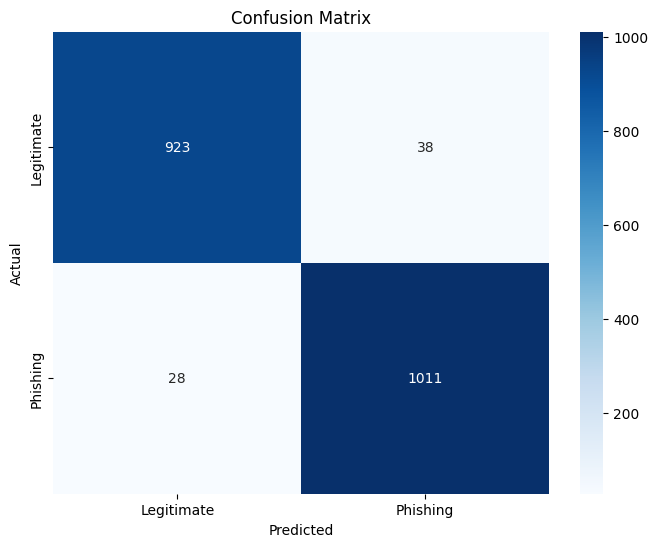

In [15]:
# first pipeline
pipeline_1 = make_pipeline(
    DecisionTreeClassifier()
)

pipeline_1.fit(X_train, y_train) # fit model

show_metrics(pipeline_1, X_test, y_test) # get metrics on testing data

In [16]:
feature_names = list(X_train.columns) # names of features

# function to show important model features
def show_feature_importances(pipeline_1, feature_names):
    feature_importances = pipeline_1[-1].feature_importances_
    top = sorted(zip(feature_importances, feature_names), reverse=True)[:10]
    for importance, name in top:
        print(f'{name.ljust(40)}{importance:.3f}')

show_feature_importances(pipeline_1, feature_names) # show feature importances for first pipeline

PctExtHyperlinks                        0.375
PctExtNullSelfRedirectHyperlinksRT      0.353
FrequentDomainNameMismatch              0.049
InsecureForms                           0.038
PctNullSelfRedirectHyperlinks           0.029
SubmitInfoToEmail                       0.014
PathLevel                               0.013
NumDash                                 0.013
QueryLength                             0.011
PctExtResourceUrls                      0.011


Note that based on our output for feature importances, it is likely that the model is overfitting. We can notice this by seeing that there are only two features that comprise over 70% of the importance of the 48 features. Despite the very high testing accuracy right off the bat, our overfitting problem suggests that this may be a bit of an illusion. Likely what is going on is the model is getting everything in the training data correct and so is getting a high test score, but compared to 100% training score, that testing score is fairly low. This leads to our next section on hyperparameter tuning.

# Second Model and Hyperparameter Tuning

To fix overfitting and maintain high model accuracy, we will need some hyperparameters for our model. This section includes:

1. Define second model using pipeline with hyperparameters
2. Find the optimal combination of these hyperparameters using `GridSearchCV`
3. Fit model with best pipeline found by `GridSearchCV`using training data
4. call `show_metrics` function on testing data

Model Accuracy:			0.868
Model Balanced Accuracy:	0.865
              precision    recall  f1-score   support

  Legitimate       0.91      0.81      0.85       961
    Phishing       0.84      0.92      0.88      1039

    accuracy                           0.87      2000
   macro avg       0.87      0.87      0.87      2000
weighted avg       0.87      0.87      0.87      2000



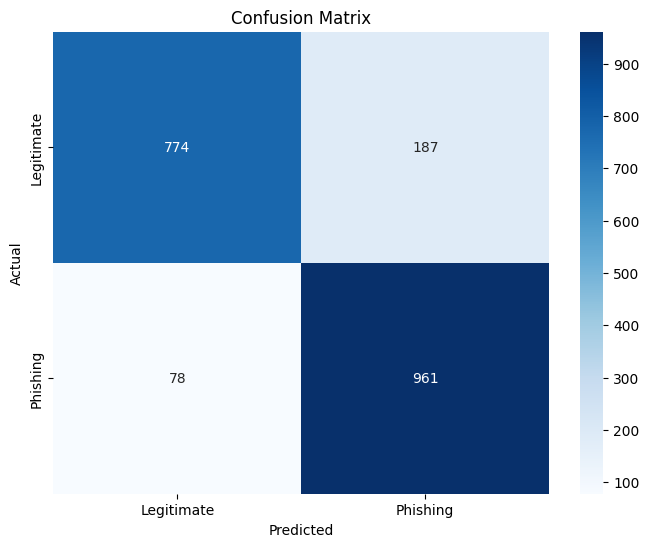

In [17]:
binary_columns = X_train.columns[(X_train.nunique() == 2) & (X_train.isin([0, 1]).all())].tolist() # define categorical columns
continuous_columns = X_train.columns.difference(binary_columns).tolist() # define numerical columns

# first pipeline component for pipeline two with hyperparameters
column_transformer = ColumnTransformer(
    transformers=[
        ('binary', 'passthrough', binary_columns),
        ('continuous', make_pipeline(PCA(n_components='mle')), continuous_columns)
    ]
)

# define pipeline two with hyperparameters
pipeline_2 = make_pipeline(
    column_transformer,
    DecisionTreeClassifier(max_depth=3, min_samples_leaf=10)
)

pipeline_2.fit(X_train, y_train) # fit second model

show_metrics(pipeline_2, X_test, y_test) # show metrics on test data for pipeline two

In [18]:
# get second pipeline feature names post pca
continuous_columns = pipeline_2.named_steps.columntransformer.named_transformers_['continuous']
n_components = continuous_columns.named_steps.pca.n_components_
feature_names = [f'pc{n}' for n in range(1, n_components + 1)] + list(binary_columns)
print(feature_names)

['pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'pc7', 'pc8', 'pc9', 'pc10', 'pc11', 'pc12', 'pc13', 'pc14', 'pc15', 'pc16', 'pc17', 'pc18', 'pc19', 'pc20', 'pc21', 'pc22', 'pc23', 'pc24', 'AtSymbol', 'TildeSymbol', 'NumHash', 'NoHttps', 'RandomString', 'IpAddress', 'DomainInSubdomains', 'DomainInPaths', 'DoubleSlashInPath', 'EmbeddedBrandName', 'ExtFavicon', 'InsecureForms', 'RelativeFormAction', 'ExtFormAction', 'AbnormalFormAction', 'FrequentDomainNameMismatch', 'FakeLinkInStatusBar', 'RightClickDisabled', 'PopUpWindow', 'SubmitInfoToEmail', 'IframeOrFrame', 'MissingTitle', 'ImagesOnlyInForm']


In [19]:
pipeline_2[0].transform(X).shape, len(feature_names) # check that feature names matches number of features in pipeline

((10000, 47), 47)

In [20]:
show_feature_importances(pipeline_2, feature_names) # show feature importances for second pipeline

NoHttps                                 0.438
pc16                                    0.161
pc12                                    0.155
EmbeddedBrandName                       0.119
pc20                                    0.108
AtSymbol                                0.018
pc9                                     0.000
pc8                                     0.000
pc7                                     0.000
pc6                                     0.000


In [21]:
list(pipeline_2.get_params().keys()) # list all possible hyperparameters

['memory',
 'steps',
 'verbose',
 'columntransformer',
 'decisiontreeclassifier',
 'columntransformer__force_int_remainder_cols',
 'columntransformer__n_jobs',
 'columntransformer__remainder',
 'columntransformer__sparse_threshold',
 'columntransformer__transformer_weights',
 'columntransformer__transformers',
 'columntransformer__verbose',
 'columntransformer__verbose_feature_names_out',
 'columntransformer__binary',
 'columntransformer__continuous',
 'columntransformer__continuous__memory',
 'columntransformer__continuous__steps',
 'columntransformer__continuous__verbose',
 'columntransformer__continuous__pca',
 'columntransformer__continuous__pca__copy',
 'columntransformer__continuous__pca__iterated_power',
 'columntransformer__continuous__pca__n_components',
 'columntransformer__continuous__pca__n_oversamples',
 'columntransformer__continuous__pca__power_iteration_normalizer',
 'columntransformer__continuous__pca__random_state',
 'columntransformer__continuous__pca__svd_solver',
 

In [22]:
# parameter grid for features we want to use
param_grid = {
    'decisiontreeclassifier__max_depth': list(range(11, 14)) ,
    'decisiontreeclassifier__min_samples_leaf': list(range(1, 4)) ,
    'columntransformer__continuous__pca__n_components': list(range(9, 12)) ,
}

In [23]:
# do grid search to find most optimal hyperparameter combinations
grid_search = GridSearchCV(
    pipeline_2,
    param_grid=param_grid,
    scoring='accuracy',
    n_jobs=1
)

grid_search.fit(X_train, y_train) # fit model with grid search

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('binary',
                                                                         'passthrough',
                                                                         ['AtSymbol',
                                                                          'TildeSymbol',
                                                                          'NumHash',
                                                                          'NoHttps',
                                                                          'RandomString',
                                                                          'IpAddress',
                                                                          'DomainInSubdomains',
                                                                          'DomainInPaths',
                                                                          'DoubleSlashInPath',
                                                                          'EmbeddedBrandName',
                                                                          'ExtFavicon',
                                                                          'InsecureForms',
                                                                          'RelativeFormAction',
                                                                          'ExtFormAction',
                                                                          'AbnormalFormActio...
                                                                          'SubdomainLevel',
                                                                          'SubdomainLevelRT',
                                                                          'UrlLength',
                                                                          'UrlLengthRT'])])),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier(max_depth=3,
                                                               min_samples_leaf=10))]),
             n_jobs=1,
             param_grid={'columntransformer__continuous__pca__n_components': [9,
                                                                              10,
                                                                              11],
                         'decisiontreeclassifier__max_depth': [11, 12, 13],
                         'decisiontreeclassifier__min_samples_leaf': [1, 2, 3]},
             scoring='accuracy')

In [24]:
grid_search.best_score_ #score of model with most optimal hyperparameters

0.9241249999999999

In [25]:
grid_search.best_params_ # hyperparameter configuration for most optimal model

{'columntransformer__continuous__pca__n_components': 11,
 'decisiontreeclassifier__max_depth': 13,
 'decisiontreeclassifier__min_samples_leaf': 2}

In [26]:
pd.DataFrame(grid_search.cv_results_) # dataframe containing information about each tested model

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_columntransformer__continuous__pca__n_components,param_decisiontreeclassifier__max_depth,param_decisiontreeclassifier__min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.103631,0.015418,0.018662,0.006479,9,11,1,{'columntransformer__continuous__pca__n_compon...,0.890000,0.903750,0.905625,0.899375,0.910000,0.901750,0.006794,25
1,0.078912,0.007619,0.007390,0.007654,9,11,2,{'columntransformer__continuous__pca__n_compon...,0.887500,0.895625,0.907500,0.903750,0.910625,0.901000,0.008409,26
2,0.078931,0.013210,0.007610,0.010553,9,11,3,{'columntransformer__continuous__pca__n_compon...,0.886875,0.900625,0.903125,0.898125,0.911250,0.900000,0.007906,27
3,0.074318,0.007744,0.004067,0.002489,9,12,1,{'columntransformer__continuous__pca__n_compon...,0.898750,0.908125,0.909375,0.901875,0.918750,0.907375,0.006908,18
4,0.079409,0.006404,0.005388,0.001961,9,12,2,{'columntransformer__continuous__pca__n_compon...,0.893750,0.900000,0.907500,0.903125,0.916250,0.904125,0.007537,24
5,0.073460,0.015880,0.003609,0.001909,9,12,3,{'columntransformer__continuous__pca__n_compon...,0.893750,0.902500,0.910000,0.900625,0.916875,0.904750,0.007971,23
6,0.094381,0.030571,0.005135,0.002319,9,13,1,{'columntransformer__continuous__pca__n_compon...,0.898125,0.916250,0.910625,0.899375,0.916250,0.908125,0.007935,16
7,0.069935,0.006482,0.003884,0.000401,9,13,2,{'columntransformer__continuous__pca__n_compon...,0.898125,0.905625,0.911250,0.905625,0.916875,0.907500,0.006275,17
8,0.079638,0.008546,0.004718,0.001926,9,13,3,{'columntransformer__continuous__pca__n_compon...,0.892500,0.908125,0.908125,0.910625,0.913125,0.906500,0.007241,19
9,0.074541,0.011687,0.003083,0.000688,10,11,1,{'columntransformer__continuous__pca__n_compon...,0.901875,0.906250,0.904375,0.900625,0.914375,0.905500,0.004848,22


Model Accuracy:			0.933
Model Balanced Accuracy:	0.934
              precision    recall  f1-score   support

  Legitimate       0.93      0.94      0.93       961
    Phishing       0.94      0.93      0.94      1039

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000



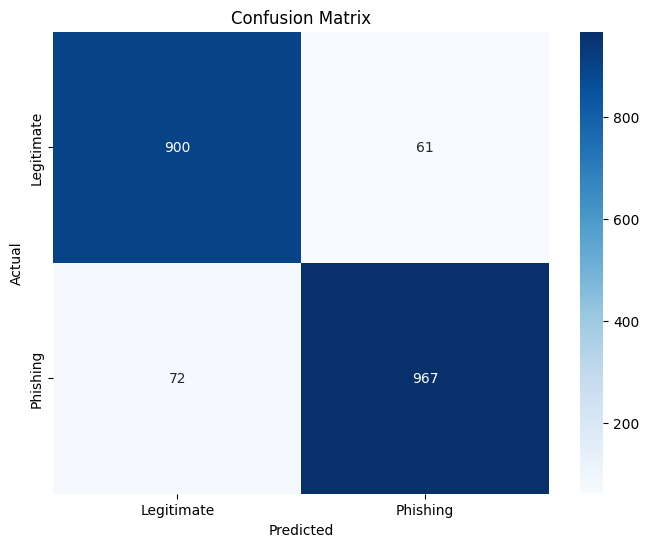

In [27]:
best_pipeline = grid_search.best_estimator_ # access the best estimator from dataframe

show_metrics(best_pipeline, X_test, y_test) # show metrics on test data for the best model

# Stabilize Model using Random Forest

Now that we have optimized the decision tree model using hyperparameters, there is one issue left to fix which is model stability. One issue with decision trees is that small changes to the data can greatly affect model output. In order to address this issue we will use random forest. Specifically this will include:

1. configuring parameters for `RandomForestClassifier` using the best pipeline found from using `DecisionTreeClassifer`
2. fitting our model with the best pipeline and `RandomForestClassifier` algorithm using training data
3. Calling `show_metrics` with testing data

Model Accuracy:			0.962
Model Balanced Accuracy:	0.961
              precision    recall  f1-score   support

  Legitimate       0.96      0.96      0.96       961
    Phishing       0.96      0.97      0.96      1039

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000



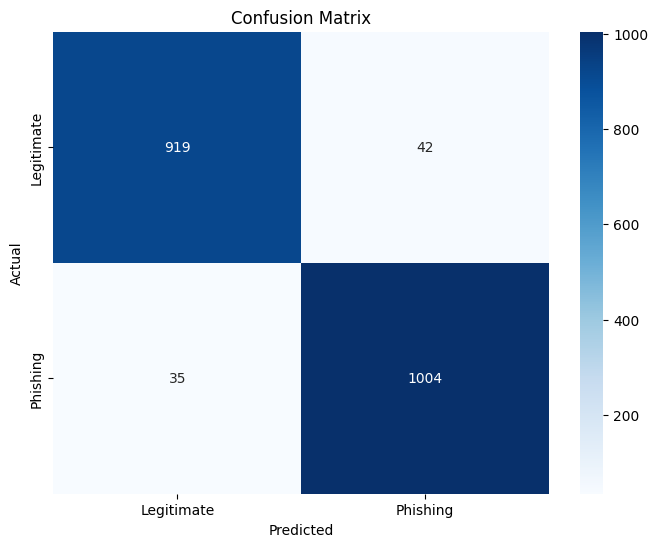

In [28]:
classifier = RandomForestClassifier() # stabilize model using random forest
best_pipeline.set_params(decisiontreeclassifier=classifier) # same parameters as decision tree classifier in best pipeline
best_pipeline.fit(X_train, y_train) # fit best pipeline using random forest

show_metrics(best_pipeline, X_test, y_test) # show metrics for test data

**Dataset Source**:
https://www.kaggle.com/datasets/shashwatwork/phishing-dataset-for-machine-learning